In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rjsdu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rjsdu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read train data

In [2]:
# Rreading train dataset
file_path = "./data/train.csv"
raw_data = pd.read_csv(file_path)
print("Data points count: ", raw_data['id'].count())
raw_data.head()


Data points count:  7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


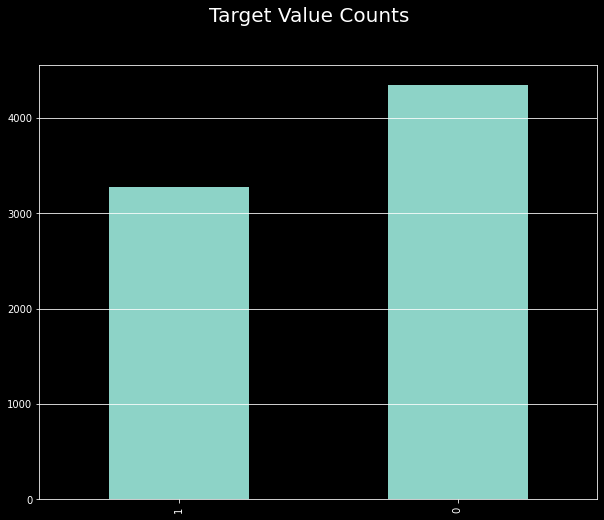

In [3]:
# Plotting target value counts
plt.figure(figsize=(10,8))
ax = raw_data['target'].value_counts().sort_values().plot(kind="bar")
ax.grid(axis="y")
plt.suptitle("Target Value Counts", fontsize=20)
plt.show()


## Missing Data

In [4]:
print("Number of missing data for column keyword: ", raw_data['keyword'].isna().sum())
print("Number of missing data for column location: ", raw_data['location'].isna().sum())
print("Number of missing data for column text: ", raw_data['text'].isna().sum())
print("Number of missing data for column target: ", raw_data['target'].isna().sum())


Number of missing data for column keyword:  61
Number of missing data for column location:  2533
Number of missing data for column text:  0
Number of missing data for column target:  0


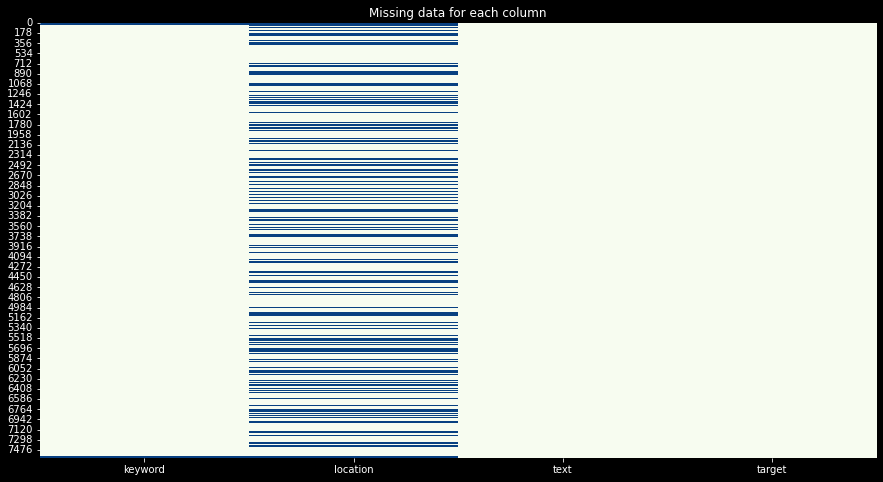

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(raw_data.drop('id', axis=1).isnull(), cbar=False, cmap="GnBu").set_title("Missing data for each column")
plt.show()

## Cleaning Data

C:\Users\rjsdu\anaconda3\envs\tf2.8\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


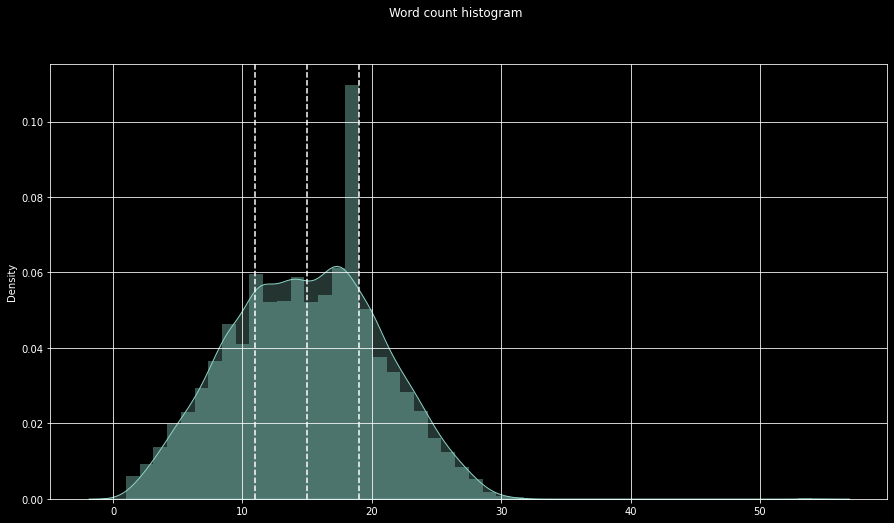

In [6]:
plt.figure(figsize=(15,8))
raw_data['word_count'] = raw_data['text'].apply(lambda x: len(x.split(" ")) )
sns.distplot(raw_data['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
plt.axvline(raw_data['word_count'].describe()['25%'], ls="--")
plt.axvline(raw_data['word_count'].describe()['50%'], ls="--")
plt.axvline(raw_data['word_count'].describe()['75%'], ls="--")

plt.grid()
plt.suptitle("Word count histogram")
plt.show()

# remove rows with under 3 words
raw_data = raw_data[raw_data['word_count']>2]
raw_data = raw_data.reset_index()


In [7]:
print("25th percentile: ", raw_data['word_count'].describe()['25%'])
print("mean: ", raw_data['word_count'].describe()['50%'])
print("75th percentile: ", raw_data['word_count'].describe()['75%'])

25th percentile:  11.0
mean:  15.0
75th percentile:  19.0


In [8]:
# Clean text columns
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')


def clean_text(each_text):

    # remove URL from text
    each_text_no_url = re.sub(r"http\S+", "", each_text)
    
    # remove numbers from text
    text_no_num = re.sub(r'\d+', '', each_text_no_url)

    # tokenize each text
    word_tokens = word_tokenize(text_no_num)
    
    # remove sptial character
    clean_text = []
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))

    # remove stop words and lower
    text_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  

    # do stemming
    stemmed_text = [stemmer.stem(w) for w in text_with_no_stop_word]
    
    return " ".join(" ".join(stemmed_text).split())


raw_data['clean_text'] = raw_data['text'].apply(lambda x: clean_text(x) )
raw_data['keyword'] = raw_data['keyword'].fillna("none")
raw_data['clean_keyword'] = raw_data['keyword'].apply(lambda x: clean_text(x) )


In [9]:
# Combine column 'clean_keyword' and 'clean_text' into one
raw_data['keyword_text'] = raw_data['clean_keyword'] + " " + raw_data["clean_text"]


## Prepare train and test data

In [10]:
feature = 'keyword_text'
label = "target"

# split train and test
X_train, X_test,y_train, y_test = model_selection.train_test_split(raw_data[feature],
                                                                   raw_data[label],
                                                                   test_size=0.3,
                                                                   random_state=0, 
                                                                   shuffle=True)


# Gradient Boosting Classifier

In [11]:
X_train_GBC = X_train.values.reshape(-1)
x_test_GBC = X_test.values.reshape(-1)


In [12]:
# Vectorize text
vectorizer = CountVectorizer()
X_train_GBC = vectorizer.fit_transform(X_train_GBC)
x_test_GBC = vectorizer.transform(x_test_GBC)


In [13]:
# Train the model
model = ensemble.GradientBoostingClassifier(learning_rate=0.1,                                            
                                            n_estimators=2000,
                                            max_depth=9,
                                            min_samples_split=6,
                                            min_samples_leaf=2,
                                            max_features=8,
                                            subsample=0.9)
model.fit(X_train_GBC, y_train)


GradientBoostingClassifier(max_depth=9, max_features=8, min_samples_leaf=2,
                           min_samples_split=6, n_estimators=2000,
                           subsample=0.9)

In [14]:
# Evaluate the model
predicted_prob = model.predict_proba(x_test_GBC)[:,1]
predicted = model.predict(x_test_GBC)

accuracy = metrics.accuracy_score(predicted, y_test)
print("Test accuracy: ", accuracy)
print(metrics.classification_report(y_test, predicted, target_names=["0", "1"]))
print("Test F-scoare: ", metrics.f1_score(y_test, predicted))

Test accuracy:  0.7955947136563877
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1309
           1       0.81      0.68      0.74       961

    accuracy                           0.80      2270
   macro avg       0.80      0.78      0.79      2270
weighted avg       0.80      0.80      0.79      2270

Test F-scoare:  0.7381489841986457


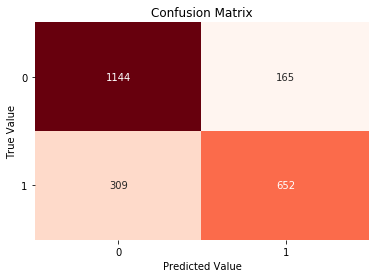

In [15]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()

# LSTM

In [16]:
# Define some hyperparameters
path_to_glove_file = './glove.6B.300d.txt' # download link: http://nlp.stanford.edu/data/glove.6B.zip
embedding_dim = 300
learning_rate = 1e-3
batch_size = 1024
epochs = 20
sequence_len = 100


In [17]:
# Define train and test labels
y_train_LSTM = y_train.values.reshape(-1,1)
y_test_LSTM = y_test.values.reshape(-1,1)

print("Training Y shape:", y_train_LSTM.shape)
print("Testing Y shape:", y_test_LSTM.shape)


Training Y shape: (5294, 1)
Testing Y shape: (2270, 1)


In [18]:
# Tokenize train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)


Vocabulary Size:  11148


In [19]:
# Pad train and test 
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=sequence_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=sequence_len)

print("Training X shape: ", X_train.shape)
print("Testing X shape: ", X_test.shape)


Training X shape:  (5294, 100)
Testing X shape:  (2270, 100)


In [20]:
# Read word embeddings
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [21]:
# Define embedding layer in Keras
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=sequence_len,
                                            trainable=False)


W0401 09:42:41.752741 4526493120 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
# Define model architecture
sequence_input = Input(shape=(sequence_len, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)
model.summary()


W0401 09:42:41.831162 4526493120 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0401 09:42:41.855180 4526493120 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0401 09:42:41.856187 4526493120 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensor

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          3344400   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           192128    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656

In [23]:
# Optimize the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])


W0401 09:42:42.555547 4526493120 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
# Train the LSTM Model
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))


Train on 5294 samples, validate on 2270 samples
Epoch 1/20
5294/5294 [==============================] - 22s 4ms/sample - loss: 0.6693 - acc: 0.5518 - val_loss: 0.5874 - val_acc: 0.7414
Epoch 2/20
5294/5294 [==============================] - 17s 3ms/sample - loss: 0.5778 - acc: 0.7263 - val_loss: 0.5394 - val_acc: 0.7502
Epoch 3/20
5294/5294 [==============================] - 17s 3ms/sample - loss: 0.5177 - acc: 0.7584 - val_loss: 0.5060 - val_acc: 0.7731
Epoch 4/20
5294/5294 [==============================] - 17s 3ms/sample - loss: 0.4906 - acc: 0.7743 - val_loss: 0.4949 - val_acc: 0.7740
Epoch 5/20
5294/5294 [==============================] - 17s 3ms/sample - loss: 0.4694 - acc: 0.7860 - val_loss: 0.4802 - val_acc: 0.7767
Epoch 6/20
5294/5294 [==============================] - 17s 3ms/sample - loss: 0.4505 - acc: 0.7981 - val_loss: 0.4792 - val_acc: 0.7767
Epoch 7/20
5294/5294 [==============================] - 18s 3ms/sample - loss: 0.4289 - acc: 0.8102 - val_loss: 0.4700 - val_acc: 

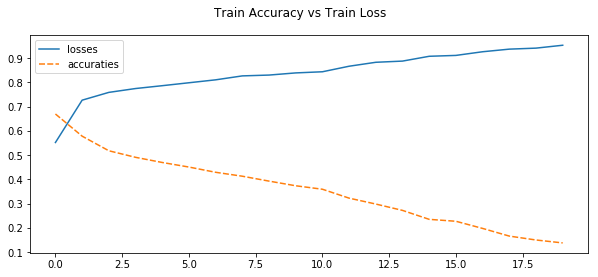

In [25]:
# Plot train accuracy and loss
accuraties = history.history['acc']
losses = history.history['loss']
accuraties_losses = list(zip(accuraties,losses))

accuraties_losses_df = pd.DataFrame(accuraties_losses, columns={"accuraties", "losses"})

plt.figure(figsize=(10,4))
plt.suptitle("Train Accuracy vs Train Loss")
sns.lineplot(data=accuraties_losses_df)
plt.show()


In [26]:
# Evaluate the model
predicted = model.predict(X_test, verbose=1, batch_size=10000)

y_predicted = [1 if each > 0.5 else 0 for each in predicted]

score, test_accuracy = model.evaluate(X_test, y_test, batch_size=10000)

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))


2270/2270 [==============================] - 2s 858us/sample - loss: 0.8005 - acc: 0.7727
Test Accuracy:  0.7726872
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1309
           1       0.76      0.68      0.72       961

    accuracy                           0.77      2270
   macro avg       0.77      0.76      0.76      2270
weighted avg       0.77      0.77      0.77      2270



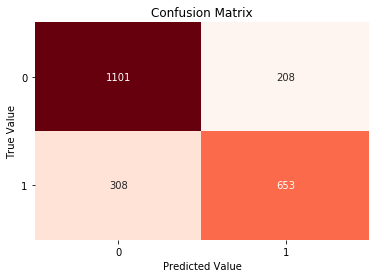

In [27]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()
